# Build GPT2

In [1]:
from dataclasses import dataclass
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

## Overall tranformer structure

- We'll be implementing the right hand side (the decoder) that composes GPT-2: each unit on the right will be a block in our transformer.

![Transformer Architecture from "Attention Is All You Need" by Vaswani et al.](./assets/transformer.png)

- The configuration below is the configuration for the entire tranformer, with each layer *h* pertaining to one of the blocks. We want to replicate the following structure from a GPT-2 model in Huggingface Transformers:

![HF Transformer](./assets/hf_transformer.png)

- The code below is the skeleton on GPT2 config and main module that will allow us to replicate that structure:

In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 256
    vocab_size: int = 65
    n_layer: int = 6
    n_head: int = 8
    n_embd: int = 384

class GPT(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        # With nn.ModuleDict() index into submodules just like a dictionary
        self.tranformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

- nn.ModuleDict allows you to index into submodules using keys, just like a dictionary.

- nn.ModuleList allows us to index into each individual layer using an index, just like with a list

## Transformer Block

- Now let's implement the Block,...

- Unlike the original GPT2 paper, establish a clean residual pathway by taking the layer norm of x and applying attention/multilayer perceptron layer to it *then* adding it to the input *x*.  Since addition allows for an adulterated gradient flow during backpropagation, this pre-layer norm configuration is the better than the post-layer norm configuration where the norm is applied after the addition. More formally, Xiong et al. (2020) have shown that if post-layer norm is used, a warm-up stage is needed to avoid training instability whereas if pre-layer norm is used, the gradients are well-behaved at initialization. See the difference between original (Post-LN) GPT-2 implementation and the 'corrected' pre-LN implementation used here:

![Source: "On Layer Normalization in the Transformer Architecture" by Xiong et al. 2020](./assets/pre_vs_post_layer_norm.png)

- Finally, onto the Block:

In [ ]:
class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config    
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

- Note again how the layer norm is applied *before* the addition to the residual stream.

- Andrej notes that attention is a communication operation, where tokens communicate with each other and aggregate information.   Thus attention can be thought of as a pooling function/weighted sum function/reduce operation.  On the other hand, the multilayer perceptron (MLP) is applied to each token individually, with no information exchanged between the tokens.  Thus attention is a *reduce* and MLP is the *map* operation and a transformer is a repeated application of MapReduce. 

## Multilayer Perceptron

- Briefly summarizing from Andrej's previous video (Let's build GPT: from scratch, in code, spelled out.), multilayer perceptron is implemented using a standard "bottleneck architecture" where the dimensions are first expanded to learn more complex representations, nonlinearity is applied to help the model learn more complex patterns, and finally the data is projected down again to keep the computational complexity in check.  

In [ ]:
class MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd*4)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(config.n_embd*4, config.n_embd)
    def forward(self,x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x    

- GPT-2 used an approximate version of GeLU because at the time of GPT-2's creation, the erf function  was very slow in TensorFlow and GPT-2 and the approximate version was used.  Today there's no reason to use the approximate version but Andrej is using the tanh approximation for veracity.  
- Also, GeLU is better than ReLU due to dead neuron problem since a local gradient is always present as seen below:

![Source: https://pytorch.org/docs/stable/generated/torch.nn.GELU.html](./assets/gelu.png)

## Causal Self Attention

- Andrej's attention implementation is a more efficient implementation of the following simple one from "Lets build GPT: from scratch, in code, spelled out":

![Source: https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py](./assets/attention_simple.png)

- Notice how in the implemenation above it is clear that the heads are parallel streams whose outputs are concatenated.
- The idea of the more efficient implementation is to make another batch dimension with *nh* so that PyTorch effectively makes batches of dimension *(B,nh)* and applies all the operations on both *B* and *nh* in parallel.  
- Each token emits query, key, and value.  Queries and keys first multiply each other to deterimine "how interesting they find each other".  
- Next, we apply an autoregressive mask to make sure the tokens only attend to tokens before them.  
- The softmax normalizes the attention so it sums to 1.
- The matrix multiply of attention with the values is a way, at every single token, to do a weigthed sum of the tokens each token finds intersting.  
- Transpose, contiguous, and view reassembles everything in memory and performs what is equivalent of a concatenation operation.
    - y.transpose(1,2): This line swaps the second and third dimensions of y. So the shape of y changes from (B, nh, T, hs) to (B, T, nh, hs).

    - .contiguous(): This is used to ensure that the tensor is stored in a contiguous block of memory, which is required for some operations in PyTorch, including view.

    - .view(B, T, C): This line reshapes the tensor y to have dimensions (B, T, C). Here, C is equal to nh*hs, which means that the last two dimensions of y (nh and hs) are flattened into a single dimension. This effectively concatenates the outputs of all the attention heads side by side.
- Finally, the output projection doesn't change the dimension of *y*, but does introduce another learnable transformation so that the output can be projected in a way that is most useful for downstream tasks.

In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        assert config.n_embd % config.n_head == 0
        #key, qury, value projections for all heads in a batch
        self.c_attn = nn.Linear(config.n_embd, config.n_embd*3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # mask to prevent attention to future tokens
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size)) # becomes available as self.bias
    def forward(self, x):
        B, T, C = x.size()
        # calculate query, key, value for all heads in batch
        qkv = self.c_attn(x) # (B,T, self.n_embd) x (self.n_embd,self.n_embd*3) = (B,T,self.n_embd*3)
        q, k, v  = qkv.split(self.n_embd, dim=2) # (B,T,self.n_embd) x 3; make each split size self.n_embd by splitting dim 2
        q = q.view(B, T, self.n_head, C//self.n_head).transpose(1,2) # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        v = v.view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        # attention materializes a large (T,T) matrix fo each query and key
        att = (q @ k.transpose(-2,-1))*(1.0/math.sqrt(k.size(-1))) # (B, nh, T, hs) x (B, nh, hs, T) = (B, nh, T, T)
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) = (B, nh, T, hs)
        # Change (B, nh, T, hs) to (B, T, nh, hs) with transpose, reassemle in memory, (B,T,C) makes nh*hs = n_embd (C)
        y = y.transpose(1,2).contiguous().view(B, T, C) 
        # output projection: additional learnable transformation
        y = self.c_proj(y) # (B, T, C)@(C, C) = (B, T, C)
        return y

## Copy over the Hugging Face GPT-2 model parameters into our model 

- Ignore the attention mask buffers (these are not parameters)
- The weights in Hugging Face version are transposed (as they are in the original TensorFlow implementation) from what PyTorch needs because they use Conv1D module.  Since we want to use plan nn.Linear, we hardcode these and transpose them.

In [2]:
class GPT(nn.Module):
    ...
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type) # HF GPT2LMHeadModel has .from_pretrained method, just like ours
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


## Forward

- The `nn.Embedding` layer in PyTorch takes an input tensor of arbitrary shape with values in the range `[0, vocab_size)` and maps each integer in that range to a dense vector of size `C` (the embedding dimension). In our case, we have an input tensor `idx` of shape `(B, T)`, where `B` is the batch size and `T` is the sequence length, then applying the embedding layer to `idx` will yield a tensor of shape `(B, T, C)`.  This is because each integer in `idx` is replaced with its corresponding embedding vector. Since the embedding vectors have `C` elements, this adds an extra dimension of size `C` to the output. So for every batch and every sequence position, an embedding of size `C` is constructed, resulting in an output of shape `(B, T, C)`.
- Also note that the position embedding is broadcast to the token embedding and the same position embedding vector is learned at (T,C) for every element in B.  This works because the position embeddings are independent of the specific sequence it's in, so it can be shared across all sequences in the batch.

In [ ]:
class GPT2(nn.Module):
    ...    
    def forward(self, idx):
        # input indices are always of shape (B, T) where B is batch size and T is block size
        B, T = idx.size()
        assert T <= self.config.block_size, "Cannot forward, model block size is exhausted."
        # forward the token and position embeddings
        pos = torch.arange(0, T , dtype=torch.long, device=idx.device) # shape (T,)
        tok_emb = self.transformer.wte(idx) # (B,T)-> (B, T, C)
        pos_emb = self.transformer.wpe(pos) # (T,)->     (T, C) 
        x = tok_emb + pos_emb               # (B, T, C) + (T, C) -> (B, T, C) via broadcasting
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layer norm and the classifier head
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # shape (B, T, vocab_size)
        return logits
    

## Generate next sequence predictions with weights from pretrained GPT2 model

- The goal is to get close to generations from the Hugging Face pipeline:

In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

- To generate next token predictions, get the next top 50 tokens so that the model does not deviate too much from likely tokens, and sample one token from this distribution.
- Concatenate the token obtained from sampling with input (or input plus previously sampled tokens) at each step.
- The sampling will not match the Hugging Face generations exactly since there's likely a parameter hiding in the pipeline that's different, but will be sensible English.

In [ ]:
num_return_sequences = 5
max_length = 30
model = GPT.from_pretrained('gpt2')
model.eval()
model.to('cuda')

# prefix tokens
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello I'm a language model, ")
x = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).repeat(num_return_sequences,1).to('cuda') # (5,8) since sent. tokenized to 8 tokens

# generate: with each loop iteration, generate one more token
torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    with torch.no_grad():
        logits = model(x) # (B,T,vocab_size)
        logits = logits[:, -1, :]  # take the logits at the last position
        probs = F.softmax(logits, dim=-1) # get the probabilities
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # get the top-50 tokens
        ix = torch.multinomial(topk_probs, num_samples=1) # sample from the top 50
        xcol = torch.gather(topk_indices, -1, ix) # select the indices of the sampled tokens
        x = torch.cat((x, xcol), dim=1) # append the sampled token to the sequence

for i in range(num_return_sequences):
    tokens = x[i,:max_length].tolist()
    decoded = enc.decode(tokens)
    print('>',decoded)

## Initialize a random model

- To do this, simply replace the GPT model initialization as below:

In [ ]:
#model = GPT.from_pretrained('gpt2')
model = GPT(GPTConfig())

## Autodetect device


- Detect the most powerful device available and use it

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print("using GPU")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = 'mps'
    print("using MPS")

- Note that we guarded against device mismatch by initializing pos on the correct device. 

In [ ]:
pos = torch.arange(0, T , dtype=torch.long, device=idx.device) # shape (T,)

## Load the Tiny Shakespeare data set for quick debugging and load a batch of data

- Andrej's favorite debugging dataset is Tiny Shakespeare which can be loaded and previewed as below:

In [2]:
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open("input.txt", "r") as f:
    text = f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


- To get the corresponding GPT-2 tokens, load the tokenizer via tiktoken's get_encoding method and encode the text data.

In [3]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


- Andrej's favorite way to create a batch is to use view, which returns a new tensor with same data but different shape.  It's a view because the returned tensor shares the same underlying data with the original tensor and a change in one will affect the other.
- Since the desired outputs for every token in the (B,T) batch are just to the right of that token, extend the buffer by one element, take all but the last token as inputs and the first token onwards as outputs: 

In [5]:
import torch
buf = torch.tensor(tokens[:24+1])
x = buf[:-1].view(4,6)
y = buf[1:].view(4,6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


## Update the forward pass to calculate the loss

- Pass in the optional targets and calculate cross entropy loss.  Cross entropy loss in PyTorch expects (B*T,vocab_size) logits and (B*T,) targets, so reshape it with view.

In [ ]:
class GPT(nn.Module):
    ...

    def forward(self, idx, targets = None):
        # input indices are always of shape (B, T) where B is batch size and T is block size
        B, T = idx.size()
        assert T <= self.config.block_size, "Cannot forward, model block size is exhausted."
        # forward the token and position embeddings
        pos = torch.arange(0, T , dtype=torch.long, device=idx.device) # shape (T,)
        tok_emb = self.transformer.wte(idx) # (B,T)-> (B, T, C)
        pos_emb = self.transformer.wpe(pos) # (T,)->     (T, C) 
        x = tok_emb + pos_emb               # (B, T, C) + (T, C) -> (B, T, C) via broadcasting
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layer norm and the classifier head
        x = self.transformer.ln_f(x)
        # --- Added code ---
        loss = None
        logits = self.lm_head(x) # shape (B, T, vocab_size)
        if targets: 
            # F.cross_entropy expects (B, T, vocab_size)-> (B*T, vocab_size) shapes for logits
            # and (B*T,) shape for targets. 
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

## Optimizer and training loop

- See the Andrew Ng's videos for a review of  [momentum](https://www.youtube.com/watch?v=k8fTYJPd3_I&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=20) and [RMSProp](https://www.youtube.com/watch?v=_e-LFe_igno&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=21) that compose the [Adam optimizer](https://www.youtube.com/watch?v=JXQT_vxqwIs&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=22).
- Make sure to zero the gradients since loss.backwards() always accumulates gradients.  
- optimizer.step() will update the parameters to (ideally) decrease the loss.  
- loss.item() will convert the loss to a float that's placed on CPU.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4)
for i in range(50):
    optimizer.zero_grad()
    logits, loss = model(x,y)
    loss.backward()
    optimizer.step()
    print(f'iteration {i}, loss = {loss.item()}')


- Running the training loop will yield the following output:

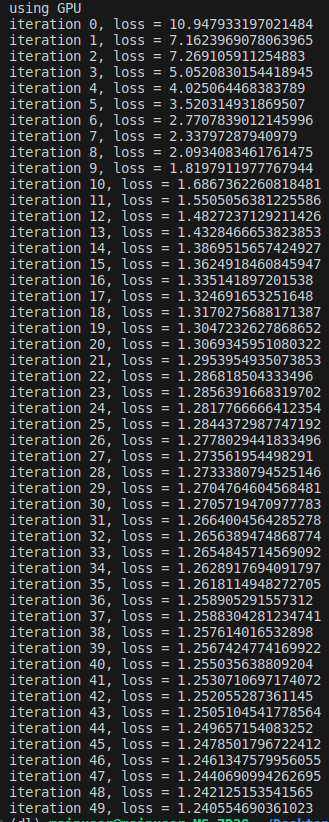

- Note that when the weights are randomly initialized, we expect each token in 0-50256 range to be equally likely.  Thus we expect loss to be around -ln(1/50257) = 10.82. Currently, the loss starts around this value, which is a good sanity check.
- Also, we can make sure that the training is set up correctly by overfitting on a single batch.  Running the training loop for 500 iterations on the same batch yields: iteration 499, loss = 0.0008159472490660846

## Data Loader Lite

- To build a simple data loader, advance by batches of size B*T, set the input *x* and output *y* as before, and loop around to the start of our tokens if run out of them: 

In [ ]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        # load the data from disk into memory
        with open("input.txt", "r") as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        self.tokens = torch.tensor(enc.encode(text))
        print(f"total tokens: {len(self.tokens)}")
        print(f"1 epoch = {len(self.tokens)//(B*T)} batches")
    
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position:self.current_position+B*T+1]
        x = (buf[:-1]).view(B,T)
        y = (buf[1:]).view(B,T)
        self.current_position += B*T
        # if run out of tokens, loop around to zero
        if self.current_position + B*T >= len(self.tokens):
            self.current_position = 0
        return x, y


## References

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). Attention Is All You Need.  arXiv preprint arXiv:1706.03762 . 

Xiong, R., Yang, Y., He, D., Zheng, K., Zheng, S., Xing, C., Zhang, H., Lan, Y., Wang, L., & Liu, T. (2020). On Layer Normalization in the Transformer Architecture. arXiv preprint arXiv:2002.04745.